已保存視覺化結果到: C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\Himawari8_wave_speed_detection\visualization\Vis_Augmentation\Aug_Visualization_Results\augmentation_visualization_vertical.png
已保存視覺化結果到: C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\Himawari8_wave_speed_detection\visualization\Vis_Augmentation\Aug_Visualization_Results\augmentation_visualization_horizontal.png


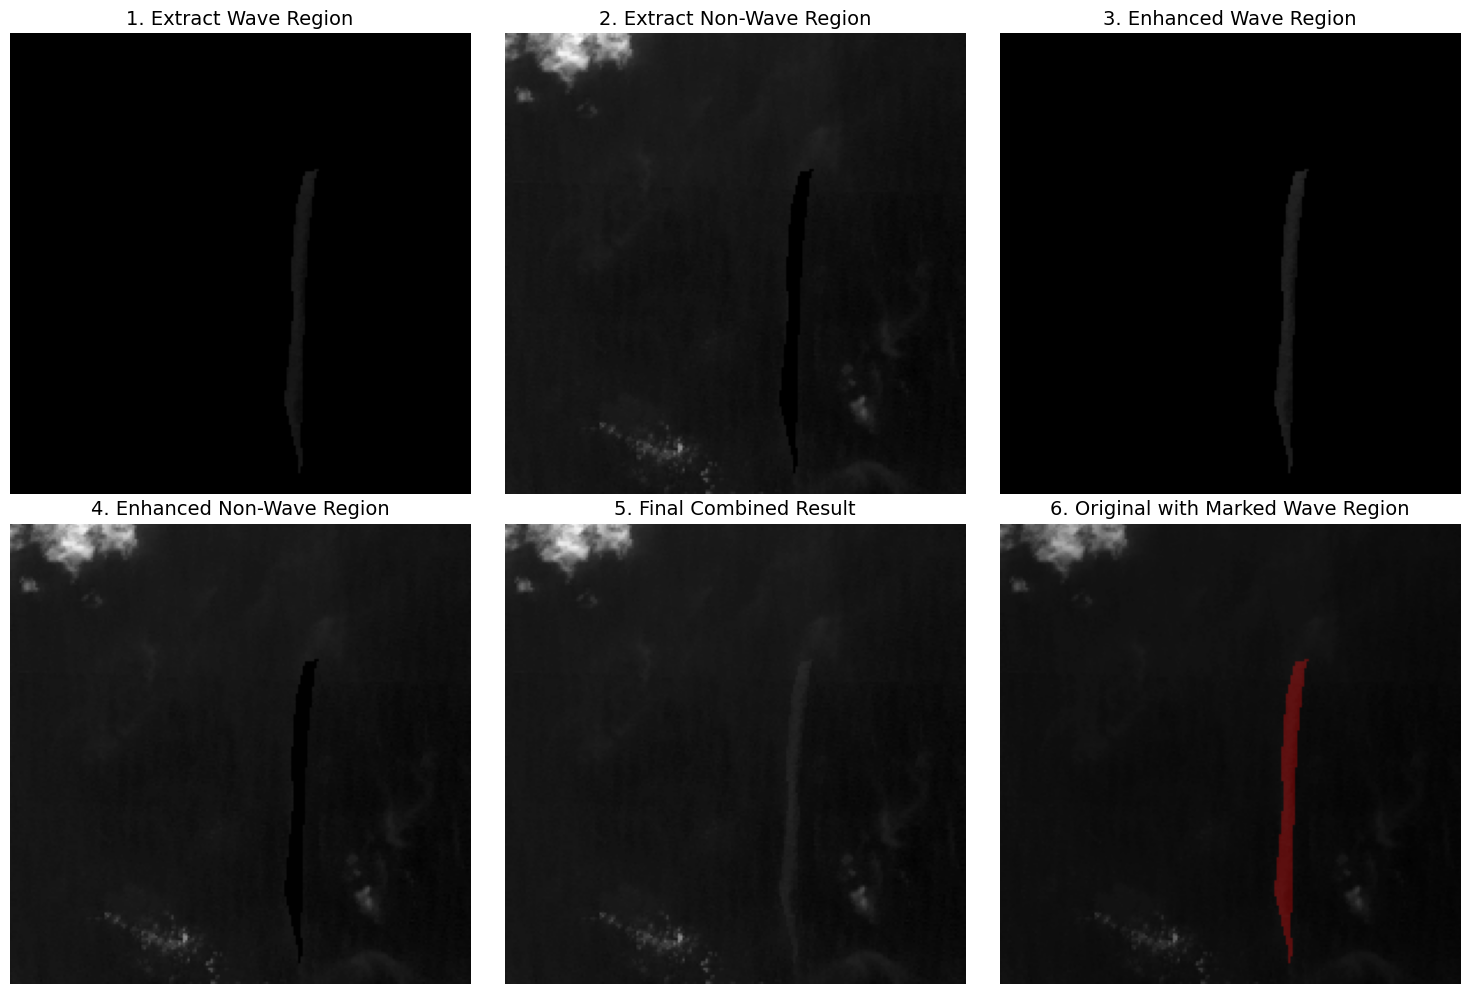

已保存內波感知增強處理過程視覺化到: C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\Himawari8_wave_speed_detection\visualization\Vis_Augmentation\Aug_Visualization_Results\wave_aware_enhancement_steps.png
所有視覺化結果已保存到: C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\Himawari8_wave_speed_detection\visualization\Vis_Augmentation\Aug_Visualization_Results


In [ ]:
# augmentation_visualizer.py

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance, ImageFilter
import math
import sys

# 定義增強函數，避免導入衝突
def load_rgb(path):
    """載入RGB格式的圖像"""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"無法載入圖像：{path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def adjust_brightness_contrast(image, brightness_factor=None, contrast_factor=None):
    """調整亮度與對比度，模擬不同日照條件"""
    if brightness_factor is None:
        brightness_factor = random.uniform(0.8, 1.2)
    if contrast_factor is None:
        contrast_factor = random.uniform(0.8, 1.2)
    
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    img = image
    if brightness_factor != 1.0:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(brightness_factor)
    if contrast_factor != 1.0:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(contrast_factor)
    return np.array(img)

def apply_msr_clahe(image):
    """應用多尺度視網膜增強(MSR)和對比度受限自適應直方圖均衡化(CLAHE)"""
    # 確保輸入是OpenCV格式
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # 轉換為LAB色彩空間（更適合CLAHE處理）
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # 應用CLAHE到亮度通道
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # 多尺度視網膜增強 (簡化版)
    # 使用三個高斯核進行視網膜增強
    sigma_list = [15, 80, 250]
    weight_list = [1/3, 1/3, 1/3]  # 均衡權重
    msr_result = np.zeros_like(cl, dtype=np.float32)
    
    for sigma, weight in zip(sigma_list, weight_list):
        # 對亮度通道應用高斯模糊
        blur = cv2.GaussianBlur(cl, (0, 0), sigma)
        # 計算視網膜響應 (對數域中的差異)
        retinex = np.log10(cl.astype(np.float32) + 1.0) - np.log10(blur.astype(np.float32) + 1.0)
        # 正規化到0-255
        retinex = cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX)
        # 累積權重結果
        msr_result += weight * retinex
    
    # 將結果轉換回8位無符號整數
    msr_result = cv2.normalize(msr_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 將處理後的亮度通道與原始a、b通道合併
    enhanced_lab = cv2.merge([msr_result, a, b])
    # 轉換回RGB色彩空間
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    return enhanced_rgb

def apply_gaussian_blur(image, radius=None):
    """應用高斯模糊，模擬成像模糊退化"""
    if radius is None:
        radius = random.uniform(0.5, 2.0)
    
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # 使用ImageFilter.GaussianBlur而不是Image.GaussianBlur
    blurred = image.filter(ImageFilter.GaussianBlur(radius=radius))
    return np.array(blurred)

def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=None):
    """
    Random Erasing 數據增強方法 (Zhong et al., AAAI 2020)
    """
    if random.random() >= p:
        return img
    
    if r2 is None:
        r2 = 1.0 / r1  # 論文中設置r2 = 1/r1
    
    h, w = img.shape[:2]
    area = h * w
    
    # 嘗試最多100次找到合適的擦除區域
    for _ in range(100):
        # 隨機選擇擦除區域的面積和寬高比
        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, r2)
        
        # 計算擦除區域的寬和高
        erase_h = int(round(math.sqrt(target_area * aspect_ratio)))
        erase_w = int(round(math.sqrt(target_area / aspect_ratio)))
        
        # 確保擦除區域在圖像範圍內
        if erase_w < w and erase_h < h:
            # 隨機選擇擦除區域的左上角坐標
            x = random.randint(0, w - erase_w)
            y = random.randint(0, h - erase_h)
            
            # 創建一個與原圖像相同形狀的副本
            img_out = img.copy()
            
            # 將擦除區域填充為隨機值
            if len(img.shape) == 3:  # 彩色圖像
                # 論文中使用的RE-R方式：每個像素使用隨機值
                noise = np.random.randint(0, 256, (erase_h, erase_w, img.shape[2]), dtype=np.uint8)
                img_out[y:y+erase_h, x:x+erase_w, :] = noise
            else:  # 灰階圖像
                noise = np.random.randint(0, 256, (erase_h, erase_w), dtype=np.uint8)
                img_out[y:y+erase_h, x:x+erase_w] = noise
            
            return img_out
    
    # 如果100次嘗試都無法找到合適的區域，返回原圖像
    return img

def random_rotation_scaling(img, mask, max_angle=15, scale_range=(0.9, 1.1)):
    """Apply random rotation and scaling to both image and mask."""
    h, w = img.shape[:2]
    
    # 隨機角度和縮放比例
    angle = random.uniform(-max_angle, max_angle)
    scale = random.uniform(scale_range[0], scale_range[1])
    
    # 計算旋轉矩陣
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    
    # 應用變換到圖像和遮罩
    img_rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    mask_rotated = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    
    return img_rotated, mask_rotated

def gentle_rotation_scaling(img, mask, max_angle=10, scale_range=(0.7, 1.3)):
    """溫和的旋轉與縮放，使用較小的角度和較窄的縮放範圍"""
    return random_rotation_scaling(img, mask, max_angle=max_angle, scale_range=scale_range)

def random_crop_and_resize(img, mask, scale_min=0.5, scale_max=0.8):
    """隨機裁剪圖像的一部分並將其調整回原始大小 (同時處理image和mask)"""
    h, w = img.shape[:2]
    scale = random.uniform(scale_min, scale_max)
    ch, cw = int(h * scale), int(w * scale)
    
    # 確保裁剪區域不超出圖像邊界
    x = random.randint(0, h - ch) if h > ch else 0
    y = random.randint(0, w - cw) if w > cw else 0
    
    # 裁剪圖像和遮罩
    img_crop = img[x:x+ch, y:y+cw]
    mask_crop = mask[x:x+ch, y:y+cw]
    
    # 將裁剪的區域調整回原始大小
    img_resized = cv2.resize(img_crop, (w, h), interpolation=cv2.INTER_LINEAR)
    
    # 使用最近鄰插值以保持mask的類別標籤
    mask_resized = cv2.resize(mask_crop, (w, h), interpolation=cv2.INTER_NEAREST)
    
    return img_resized, mask_resized

def gentle_crop_and_resize(img, mask, scale_min=0.7, scale_max=0.9):
    """較溫和的裁剪，使用較大的裁剪範圍以保留更多內波結構"""
    return random_crop_and_resize(img, mask, scale_min=scale_min, scale_max=scale_max)

def safe_cutmix(img1, mask1, img2, mask2, alpha=3.0, max_attempts=10):
    """安全CutMix：避免切割現有內波區域"""
    for _ in range(max_attempts):
        # 正常CutMix處理前先計算切割區域
        h, w = img1.shape[:2]
        lam = np.random.beta(alpha, alpha)
        cut_w = int(w * np.sqrt(1 - lam))
        cut_h = int(h * np.sqrt(1 - lam))
        
        cx, cy = random.randint(0, w), random.randint(0, h)
        x1 = np.clip(cx - cut_w//2, 0, w)
        y1 = np.clip(cy - cut_h//2, 0, h)
        x2 = np.clip(cx + cut_w//2, 0, w)
        y2 = np.clip(cy + cut_h//2, 0, h)
        
        # 檢查區域內是否有內波（白色像素）
        # 簡單處理：轉為灰度後檢查亮度值
        if len(mask1.shape) > 2:
            region_mask = cv2.cvtColor(mask1[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        else:
            region_mask = mask1[y1:y2, x1:x2]
            
        if np.sum(region_mask > 200) < 10:  # 假設少於10個白色像素表示無內波
            # 安全區域，可以進行混合
            img_cm = img1.copy()
            mask_cm = mask1.copy()
            img_cm[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
            mask_cm[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]
            return img_cm, mask_cm
    
    # 若多次嘗試都無法找到合適區域，使用邊界混合的方式
    # 選擇圖像邊緣區域進行混合（通常邊緣不含內波）
    edge_width = w // 4
    edge_height = h // 4
    
    # 隨機選擇一個邊緣區域
    edge_choice = random.randint(0, 3)
    if edge_choice == 0:  # 上邊緣
        img_cm = img1.copy()
        mask_cm = mask1.copy()
        img_cm[:edge_height, :] = img2[:edge_height, :]
        mask_cm[:edge_height, :] = mask2[:edge_height, :]
    elif edge_choice == 1:  # 右邊緣
        img_cm = img1.copy()
        mask_cm = mask1.copy()
        img_cm[:, -edge_width:] = img2[:, -edge_width:]
        mask_cm[:, -edge_width:] = mask2[:, -edge_width:]
    elif edge_choice == 2:  # 下邊緣
        img_cm = img1.copy()
        mask_cm = mask1.copy()
        img_cm[-edge_height:, :] = img2[-edge_height:, :]
        mask_cm[-edge_height:, :] = mask2[-edge_height:, :]
    else:  # 左邊緣
        img_cm = img1.copy()
        mask_cm = mask1.copy()
        img_cm[:, :edge_width] = img2[:, :edge_width]
        mask_cm[:, :edge_width] = mask2[:, :edge_width]
    
    return img_cm, mask_cm

def wave_aware_enhancement(img, mask):
    """根據內波區域採用不同增強策略"""
    # 檢測內波區域
    if len(mask.shape) > 2:
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    else:
        gray_mask = mask
    
    # 創建內波區域遮罩
    wave_mask = (gray_mask > 200).astype(np.uint8) * 255
    non_wave_mask = (gray_mask <= 200).astype(np.uint8) * 255
    
    # 對內波區域應用對比度增強和MSR+CLAHE
    enhanced_img = img.copy()
    
    # 1. 處理內波區域 - 僅增強對比度和清晰度
    wave_only = img.copy()
    wave_only[non_wave_mask == 255] = 0  # 僅保留內波區域
    
    # 內波區域增強 - 對比度提高
    wave_enhanced = adjust_brightness_contrast(wave_only, brightness_factor=1.0, contrast_factor=1.3)
    
    # 2. 處理非內波區域 - 可以應用更多變形
    non_wave_only = img.copy()
    non_wave_only[wave_mask == 255] = 0  # 僅保留非內波區域
    
    # 非內波區域增強 - 隨機選擇一種增強方法
    non_wave_methods = [
        lambda i: adjust_brightness_contrast(i, random.uniform(0.8, 1.2), random.uniform(0.9, 1.1)),
        lambda i: apply_gaussian_blur(i, random.uniform(0.5, 1.5)),
        lambda i: random_erasing(i, p=1.0)
    ]
    
    non_wave_enhanced = non_wave_methods[0](non_wave_only)  # 固定使用第一種方法用於視覺化
    
    # 合併兩個區域
    enhanced_img = cv2.add(wave_enhanced, non_wave_enhanced)
    
    return enhanced_img, mask.copy()

class AugmentationVisualizer:
    """增強方法視覺化工具類"""
    
    def __init__(self, output_dir):
        """初始化視覺化工具"""
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # 設置隨機種子以確保結果可重現
        random.seed(42)
        np.random.seed(42)
    
    def apply_augmentations(self, img1, mask1, img2=None, mask2=None):
        """應用所有增強方法並返回結果"""
        results = {}
        
        # 原始圖像
        results['Original'] = (img1.copy(), mask1.copy())
        
        # 1. 亮度與對比度調整
        bc_img = adjust_brightness_contrast(img1.copy(), brightness_factor=1.2, contrast_factor=1.2)
        results['Brightness & Contrast'] = (bc_img, mask1.copy())
        
        # 2. MSR + CLAHE 增強
        msr_img = apply_msr_clahe(img1.copy())
        results['MSR + CLAHE'] = (msr_img, mask1.copy())
        
        # 3. 高斯模糊
        blur_img = apply_gaussian_blur(img1.copy(), radius=1.5)
        results['Gaussian Blur'] = (blur_img, mask1.copy())
        
        # 4. 隨機擦除
        erase_img = random_erasing(img1.copy(), p=1.0)
        results['Random Erasing'] = (erase_img, mask1.copy())
        
        # 5. 旋轉與縮放
        rot_img, rot_mask = random_rotation_scaling(img1.copy(), mask1.copy(), 
                                              max_angle=15, 
                                              scale_range=(0.9, 1.1))
        results['Rotation & Scaling'] = (rot_img, rot_mask)
        
        # 6. 溫和旋轉
        gentle_rot_img, gentle_rot_mask = gentle_rotation_scaling(img1.copy(), mask1.copy(), 
                                                            max_angle=7, 
                                                            scale_range=(0.95, 1.05))
        results['Gentle Rotation'] = (gentle_rot_img, gentle_rot_mask)
        
        # 7. 隨機裁剪
        crop_img, crop_mask = random_crop_and_resize(img1.copy(), mask1.copy(), 
                                               scale_min=0.5, 
                                               scale_max=0.8)
        results['Random Cropping'] = (crop_img, crop_mask)
        
        # 8. 溫和裁剪
        gentle_crop_img, gentle_crop_mask = gentle_crop_and_resize(img1.copy(), mask1.copy(), 
                                                             scale_min=0.7, 
                                                             scale_max=0.9)
        results['Gentle Cropping'] = (gentle_crop_img, gentle_crop_mask)
        
        # 9. CutMix (需要兩張圖像)
        if img2 is not None and mask2 is not None:
            cutmix_img, cutmix_mask = safe_cutmix(img1.copy(), mask1.copy(), 
                                            img2.copy(), mask2.copy())
            results['CutMix'] = (cutmix_img, cutmix_mask)
        
        # 10. 內波感知增強
        wave_img, wave_mask = wave_aware_enhancement(img1.copy(), mask1.copy())
        results['Wave-Aware Enhancement'] = (wave_img, wave_mask)
        
        return results
    
    def visualize_wave_aware_steps(self, img, mask):
        """顯示內波感知增強的中間步驟"""
        # 處理遮罩
        if len(mask.shape) > 2:
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        else:
            gray_mask = mask
        
        # 創建內波區域與非內波區域遮罩
        wave_mask = (gray_mask > 200).astype(np.uint8) * 255
        non_wave_mask = (gray_mask <= 200).astype(np.uint8) * 255
        
        # 1. 提取內波區域
        wave_only = img.copy()
        wave_only[non_wave_mask == 255] = 0
        
        # 2. 提取非內波區域
        non_wave_only = img.copy()
        non_wave_only[wave_mask == 255] = 0
        
        # 3. 內波區域增強 - 對比度提高
        wave_enhanced = adjust_brightness_contrast(wave_only, brightness_factor=1.0, contrast_factor=1.3)
        
        # 4. 非內波區域增強 - 這裡用亮度對比度調整作為示例
        non_wave_enhanced = adjust_brightness_contrast(non_wave_only, 
                                                brightness_factor=random.uniform(0.8, 1.2), 
                                                contrast_factor=random.uniform(0.9, 1.1))
        
        # 5. 最終合併結果
        final_enhanced = cv2.add(wave_enhanced, non_wave_enhanced)
        
        # 彩色遮罩可視化 (用於突出顯示內波區域)
        color_mask = np.zeros_like(img)
        color_mask[wave_mask == 255] = [255, 0, 0]  # 紅色標記內波區域
        
        # 創建帶有半透明遮罩的原始圖像
        overlay = img.copy()
        alpha = 0.3
        marked_img = cv2.addWeighted(overlay, 1-alpha, color_mask, alpha, 0)
        
        return [
            wave_only,          # 步驟1: 僅內波區域
            non_wave_only,      # 步驟2: 僅非內波區域
            wave_enhanced,      # 步驟3: 內波區域增強
            non_wave_enhanced,  # 步驟4: 非內波區域增強
            final_enhanced,     # 步驟5: 最終合併結果
            marked_img          # 步驟6: 標記的原始圖像(用於參考)
        ]
    
    def create_grid_visualization(self, augmentation_results, mode='vertical'):
        """創建網格視覺化，展示所有增強方法的效果"""
        titles = list(augmentation_results.keys())
        images = [result[0] for result in augmentation_results.values()]
        masks = [result[1] for result in augmentation_results.values()]
        
        n = len(titles)
        
        if mode == 'vertical':
            # 創建直式佈局 (一列三個子圖：標題，圖像，標註)
            fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
            
            for i, (title, img, mask) in enumerate(zip(titles, images, masks)):
                # 標題
                axes[i, 0].text(0.5, 0.5, title, fontsize=14, ha='center', va='center', fontweight='bold')
                axes[i, 0].axis('off')
                
                # 圖像
                axes[i, 1].imshow(img)
                axes[i, 1].set_title("Satellite Image", fontsize=12)
                axes[i, 1].axis('off')
                
                # 標註
                axes[i, 2].imshow(mask)
                axes[i, 2].set_title("Mask", fontsize=12)
                axes[i, 2].axis('off')
            
            filename = 'augmentation_visualization_vertical.png'
            
        else:  # 'horizontal' mode
            # 創建橫式佈局 (兩列，每列n個子圖)
            fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
            
            for i, (title, img, mask) in enumerate(zip(titles, images, masks)):
                # 上排顯示衛星圖像
                axes[0, i].imshow(img)
                axes[0, i].set_title(title, fontsize=14)
                axes[0, i].axis('off')
                
                # 下排顯示對應的標註圖
                axes[1, i].imshow(mask)
                axes[1, i].axis('off')
            
            # 添加大標題
            axes[0, 0].text(-0.2, 0.5, "Images", fontsize=16, ha='center', va='center', 
                          fontweight='bold', transform=axes[0, 0].transAxes)
            axes[1, 0].text(-0.2, 0.5, "Masks", fontsize=16, ha='center', va='center', 
                          fontweight='bold', transform=axes[1, 0].transAxes)
            
            filename = 'augmentation_visualization_horizontal.png'
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"已保存視覺化結果到: {os.path.join(self.output_dir, filename)}")
        
        return fig
    
    def visualize_wave_aware_process(self, img, mask):
        """視覺化內波感知增強的處理過程"""
        wave_aware_steps = self.visualize_wave_aware_steps(img, mask)
        step_titles = [
            '1. Extract Wave Region', 
            '2. Extract Non-Wave Region',
            '3. Enhanced Wave Region', 
            '4. Enhanced Non-Wave Region',
            '5. Final Combined Result', 
            '6. Original with Marked Wave Region'
        ]
        
        fig = plt.figure(figsize=(15, 10))
        for i, (img, title) in enumerate(zip(wave_aware_steps, step_titles)):
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(title, fontsize=14)
            plt.axis('off')
        
        plt.tight_layout()
        filename = 'wave_aware_enhancement_steps.png'
        plt.savefig(os.path.join(self.output_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"已保存內波感知增強處理過程視覺化到: {os.path.join(self.output_dir, filename)}")
        
        return fig
    
    def run_visualization(self, image1_path, mask1_path, image2_path=None, mask2_path=None):
        """執行完整的視覺化流程"""
        # 載入圖像
        img1 = load_rgb(image1_path)
        mask1 = load_rgb(mask1_path)
        
        img2 = None
        mask2 = None
        if image2_path and mask2_path:
            img2 = load_rgb(image2_path)
            mask2 = load_rgb(mask2_path)
        
        # 應用增強方法
        augmentation_results = self.apply_augmentations(img1, mask1, img2, mask2)
        
        # 創建網格視覺化 (直式)
        self.create_grid_visualization(augmentation_results, mode='vertical')
        
        # 創建網格視覺化 (橫式)
        self.create_grid_visualization(augmentation_results, mode='horizontal')
        
        # 視覺化內波感知增強處理過程
        self.visualize_wave_aware_process(img1, mask1)
        
        print("所有視覺化結果已保存到:", self.output_dir)

def main():
    """主函數"""
    base_dir = r"C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\Himawari8_wave_speed_detection\visualization\Vis_Augmentation"
    output_dir = os.path.join(base_dir, "Aug_Visualization_Results")
    
    # 圖像路徑
    image1_path = os.path.join(base_dir, "Aug_Visualization", "201906180340.png")
    mask1_path = os.path.join(base_dir, "Aug_Visualization", "201906180340_mask.png")
    image2_path = os.path.join(base_dir, "Aug_Visualization", "201906080720.png")
    mask2_path = os.path.join(base_dir, "Aug_Visualization", "201906080720_mask.png")
    
    # 創建視覺化工具實例
    visualizer = AugmentationVisualizer(output_dir)
    
    # 執行視覺化
    visualizer.run_visualization(image1_path, mask1_path, image2_path, mask2_path)

if __name__ == "__main__":
    main()